# eICU Experiments

In [47]:
import tensorflow as tf
import numpy as np
import h5py
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import sklearn
from sklearn import metrics
import seaborn as sns
import random

Upload the data:

In [50]:
def get_data(test=True):
    hf = h5py.File('../data/eICU_data.csv', 'r')
    data_total = np.array(hf.get('x'))
    endpoints_total = np.array(hf.get('y'))
    hf.close()
    data_train, data_val, y_train, endpoints_total_val = train_test_split(data_total[:int(len(data_total) * 0.85)],
                                                                          endpoints_total[:int(len(data_total) * 0.85)],
                                                                          test_size=0.20,
                                                                          random_state=42)
    if test:
        data_val = data_total[int(len(data_total) * 0.85):]
        endpoints_total_val = endpoints_total[int(len(data_total) * 0.85):]
    return data_train, data_val, y_train, endpoints_total_val

In [51]:
def get_normalized_data(data, patientid, mins, scales):
    return ((data[data['patientunitstayid'] == patientid] - mins) /
            scales).drop(["patientunitstayid", "ts"], axis=1).fillna(0).values


def batch_generator(data_train, data_val, endpoints_total_val, batch_size, max_n_step, mode="train"):
    while True:
        if mode == "train":
            for i in range(len(data_train) // batch_size):
                time_series = data_train[i * batch_size: (i + 1) * batch_size]
                yield time_series
        elif mode == "val":
            for i in range(len(data_val) // batch_size):
                time_series = data_val[i * batch_size: (i + 1) * batch_size]
                time_series_endpoint = endpoints_total_val[i * batch_size: (i + 1) * batch_size]
                yield time_series, time_series_endpoint
        else:
            raise ValueError("The mode has to be in {train, val}")


Insert the name of the job in ex_name:

In [52]:
ex_name="hyperopt_LSTMprob_10_8-8_2019-10-02_bcbff"

Get the data:

In [53]:
batch_size=128
modelpath = "../models/{}/{}".format(ex_name, ex_name)
data_train, data_val, endpoints_total_train, endpoints_total_val = get_data(test=True)

Save the labels:

In [54]:
labels_val_all = endpoints_total_val
labels_val_all = np.array(labels_val_all)
labels_val_all = np.reshape(labels_val_all, (-1,labels_val_all.shape[-1]))
labels_12 = labels_val_all[:,2]
labels_1 = labels_val_all[:,0]
labels_6 = labels_val_all[:,1]
labels_24 = labels_val_all[:,3]
hosp_disc_1 = labels_val_all[:,4]
hosp_disc_6 = labels_val_all[:,5]
hosp_disc_12 = labels_val_all[:,6]
hosp_disc_24 = labels_val_all[:,7]
u_disc_1 = labels_val_all[:,8]
u_disc_6 = labels_val_all[:,9]
u_disc_12 = labels_val_all[:,10]
u_disc_24 = labels_val_all[:, 11]
labels_1 = labels_1.astype(int)
labels_6 = labels_6.astype(int)
labels_12 = labels_12.astype(int)
labels_24 = labels_24.astype(int)
hosp_disc_12 = hosp_disc_12.astype(int)
hosp_disc_24 = hosp_disc_24.astype(int)
hosp_disc_1 = hosp_disc_1.astype(int)
hosp_disc_6 = hosp_disc_6.astype(int)

## Create heat-maps, trajectories and probability distributions

In [57]:
som_dim = [8,8]
latent_dim=10

In [58]:
def z_dist_flat(z_e, embeddings):
    """Computes the distances between the encodings and the embeddings."""
    emb = np.reshape(embeddings, (som_dim[0]*som_dim[1], -1))
    z = np.reshape(z_e, (z_e.shape[0], 1, latent_dim))
    z = np.tile(z, [1,som_dim[0]*som_dim[1], 1])
    z_dist = np.square(z-emb)
    z_dist_red = np.sum(z_dist, axis=-1)
    return z_dist_red

In [59]:
tf.reset_default_graph()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph(modelpath+".meta")
    saver.restore(sess, modelpath)
    graph = tf.get_default_graph()
    k = graph.get_tensor_by_name("k/k:0")
    z_e = graph.get_tensor_by_name("z_e_sample/z_e:0")
    next_z_e = graph.get_tensor_by_name("prediction/next_state/next_z_e:0")
    x = graph.get_tensor_by_name("inputs/x:0")
    is_training = graph.get_tensor_by_name("is_training/is_training:0")
    graph = tf.get_default_graph()
    init_1 = graph.get_tensor_by_name("prediction/next_state/init_state:0")
    z_e_p = graph.get_tensor_by_name("prediction/next_state/input_lstm:0")
    state1 = graph.get_tensor_by_name("prediction/next_state/next_state:0")
    q = graph.get_tensor_by_name("q/distribution/q:0")
    embeddings = graph.get_tensor_by_name("embeddings/embeddings:0")
    z_p = graph.get_tensor_by_name("input_rec/z_e:0")
    reconstruction = graph.get_tensor_by_name("reconstruction_e/x_hat:0")
    
    print("Evaluation...")
    training_dic = {is_training: True, z_e_p: np.zeros((max_n_step * len(data_val), latent_dim)), 
                    init_1: np.zeros((2, batch_size, 10))}
    z_e_all = sess.run(z_e, feed_dict={x: data_val})
    z_e_all = z_e_all.reshape((-1, 72, latent_dim))
    k_all = sess.run(k, feed_dict={x: data_val})
    k_all = k_all.reshape((-1, 72))
    qq = sess.run(q, feed_dict={x: data_val})

INFO:tensorflow:Restoring parameters from ../models/hyperopt_LSTMprob_10_8-8_2019-10-02_bcbff/hyperopt_LSTMprob_10_8-8_2019-10-02_bcbff
Evaluation...


APACHE score heatmap:

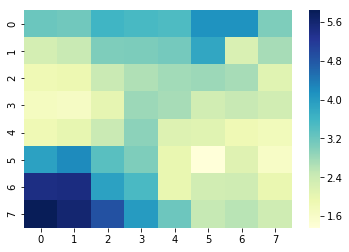

In [62]:
labels = labels_1
ones = np.ones((len(np.reshape(k_all, (-1)))))
clust_matr1 = np.zeros(64)
clust_matr2 = np.zeros(64)
for i in range(64):
    s1 = np.sum(labels[np.where(np.reshape(k_all, (-1))==i)]) / np.sum(ones[np.where(np.reshape(k_all, (-1))==i)])
    clust_matr1[i] = s1
clust_matr1 = np.reshape(clust_matr1, (8,8))
ax = sns.heatmap(clust_matr1, cmap="YlGnBu")
plt.show()

MORTALITY score of the next 24 hours:

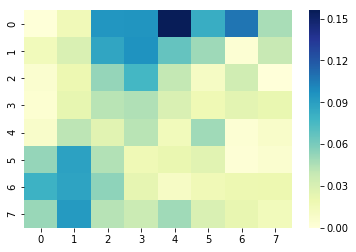

In [67]:
labels = u_disc_24
ones = np.ones((len(np.reshape(k_all, (-1)))))
clust_matr1 = np.zeros(64)
clust_matr2 = np.zeros(64)
for i in range(64):
    s1 = np.sum(labels[np.where(np.reshape(k_all, (-1))==i)]) / np.sum(ones[np.where(np.reshape(k_all, (-1))==i)])
    clust_matr1[i] = s1
clust_matr1 = np.reshape(clust_matr1, (8,8))
ax = sns.heatmap(clust_matr1, cmap="YlGnBu")
plt.show()

Trajectories:

In [68]:
T = []
for i in range(1000):
    h = np.reshape(u_disc_1, (-1,72))
    if np.max(h[i]) == 1:
        T.append(i)

In [69]:
ind_r = np.random.random_integers(0, 50, 10)
ind_s = np.random.random_integers(0, 500, 10)
T = np.array(T)
a = np.concatenate([ind_s, T[ind_r]])

/cluster/home/lauraman/software/anaconda/envs/mt/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 50 + 1) instead
  """Entry point for launching an IPython kernel.
/cluster/home/lauraman/software/anaconda/envs/mt/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: This function is deprecated. Please call randint(0, 500 + 1) instead
  


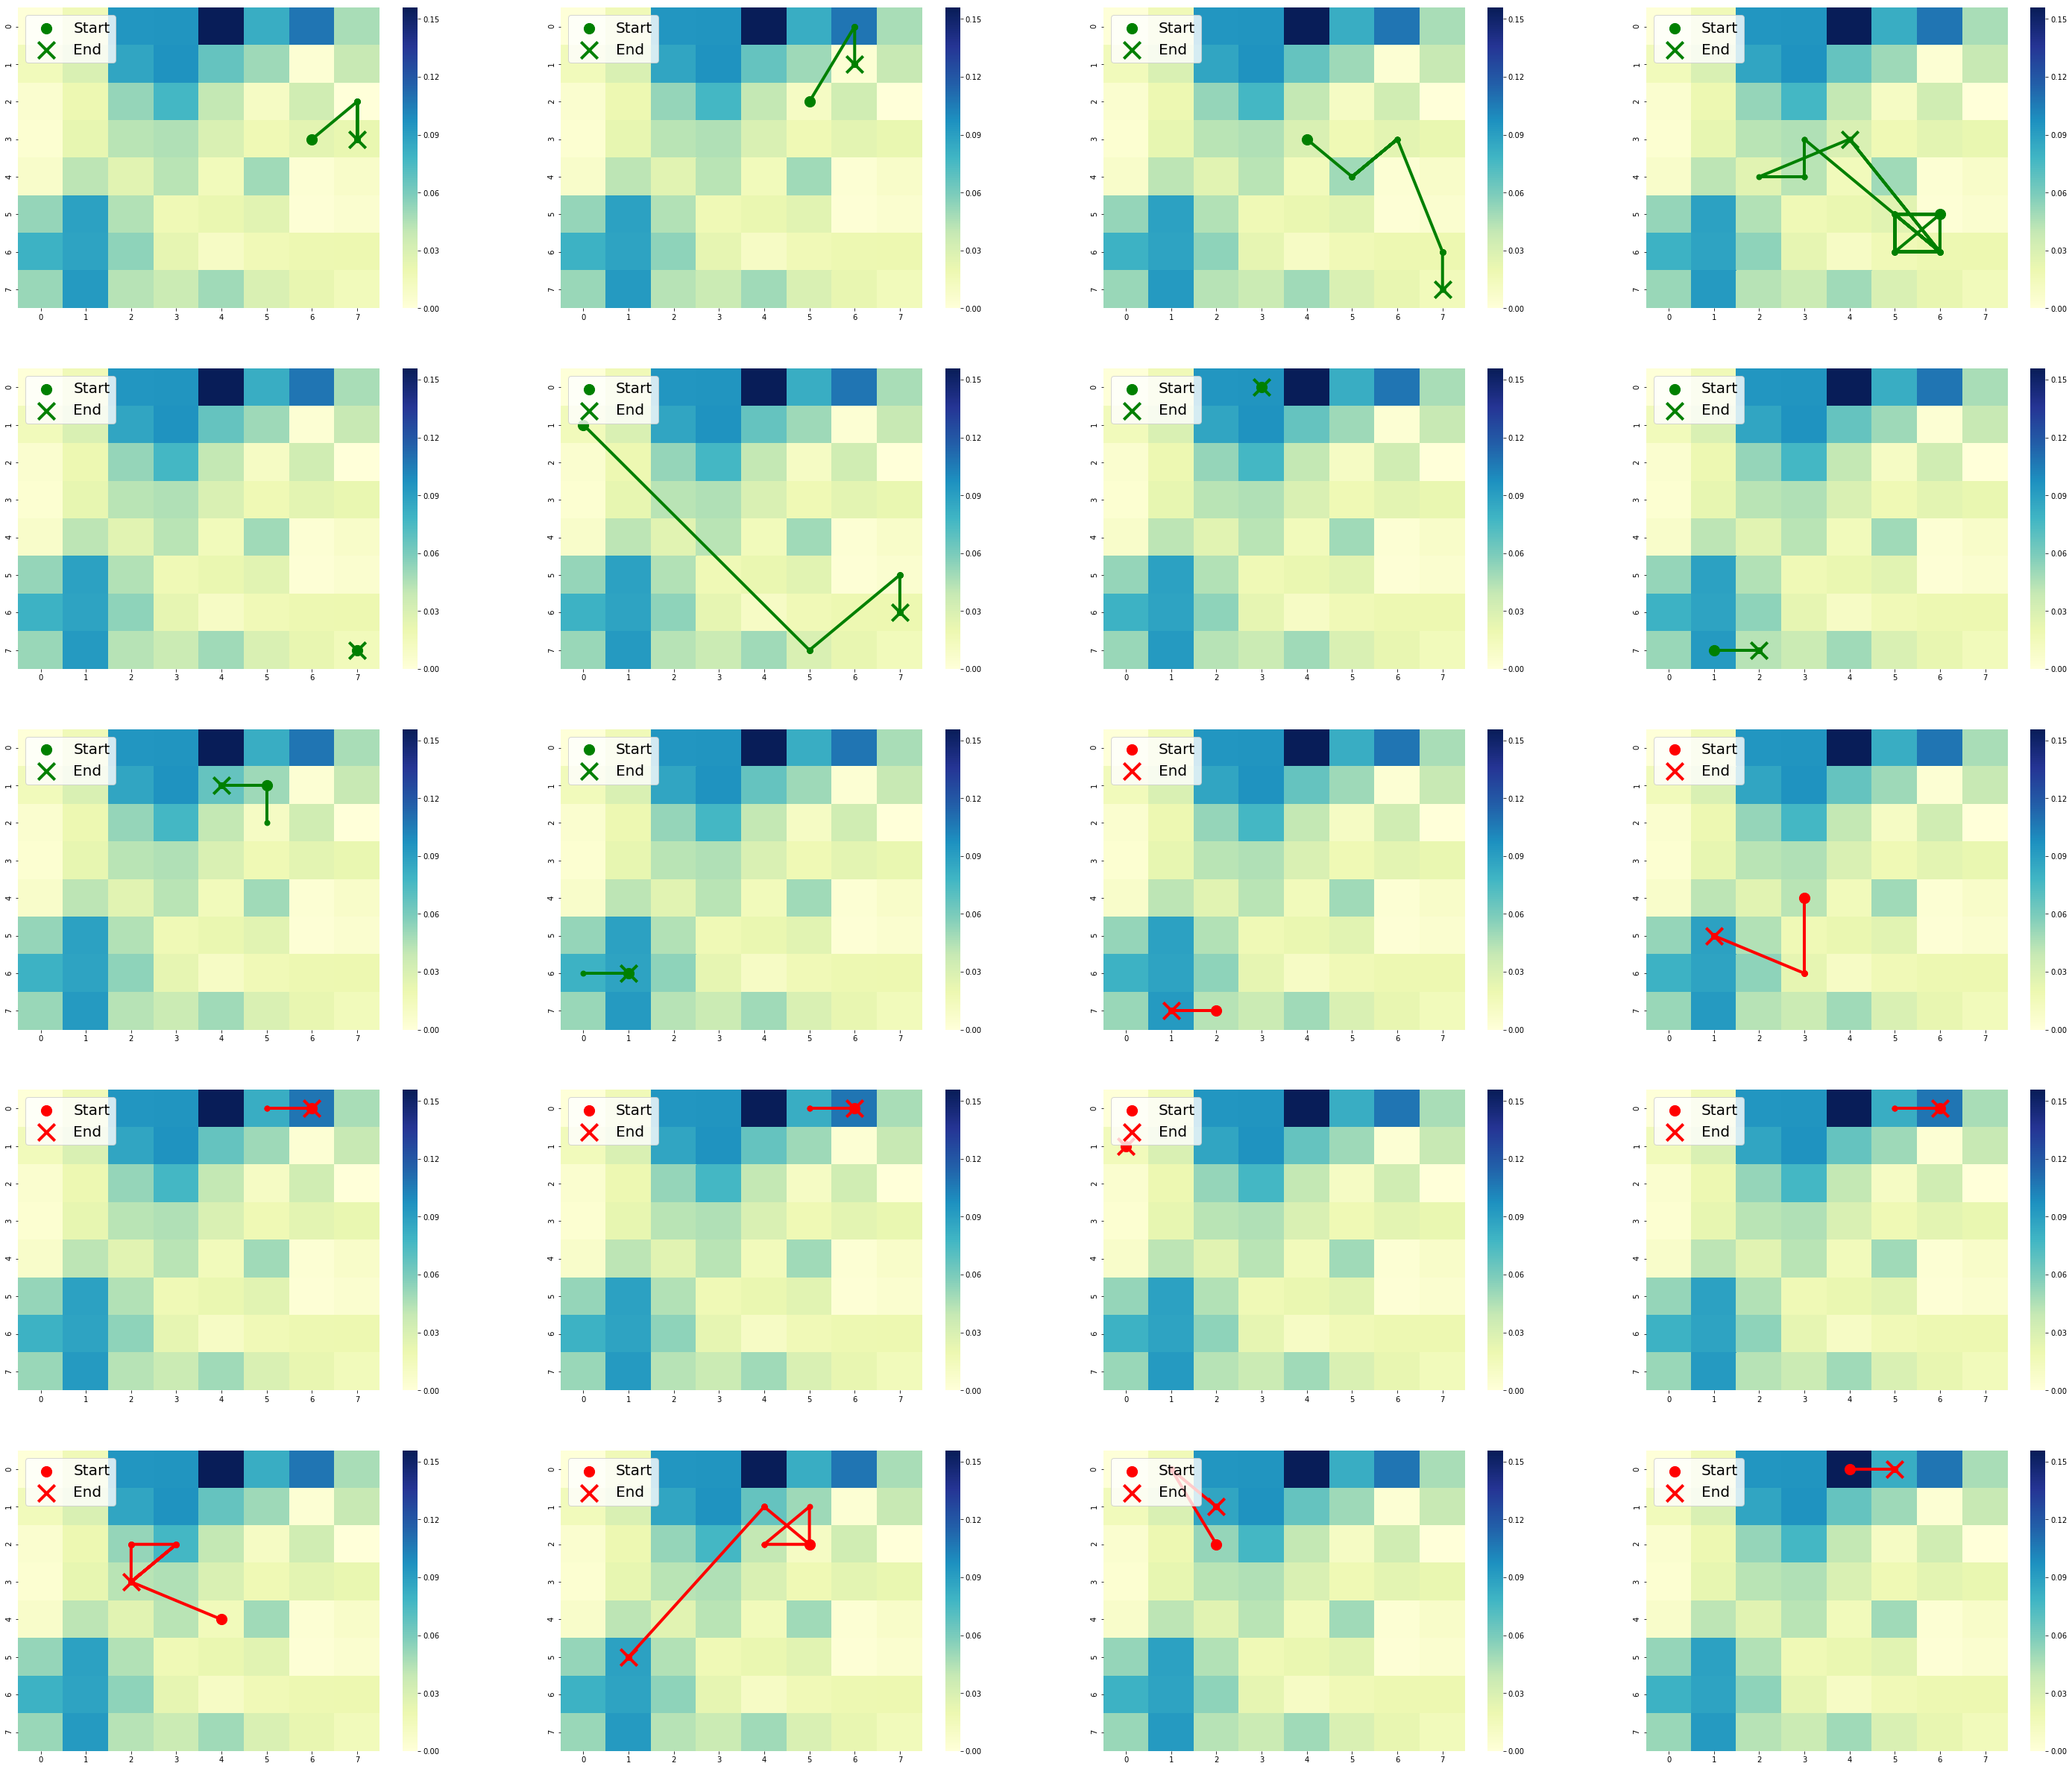

In [73]:
labels = u_disc_24
it = 0
fig, ax = plt.subplots(5, 4, figsize=(50,43)) 
ones = np.ones((len(np.reshape(k_all, (-1)))))
clust_matr1 = np.zeros(64)
clust_matr2 = np.zeros(64)
for i in range(64):
    s1 = np.sum(labels[np.where(np.reshape(k_all, (-1)) == i)]) / np.sum(ones[np.where(np.reshape(k_all, (-1))==i)])
    clust_matr1[i] = s1
clust_matr1 = np.reshape(clust_matr1, (8,8))
for t in a:
    #fig, ax = plt.subplots(figsize=(10,7.5)) 
    if it > 9:
        c = "r"
        #print(t)
    else:
        c = "g"
    cc = it % 4
    rr = it // 4
    g = sns.heatmap(clust_matr1, cmap="YlGnBu",ax=ax[rr][cc])
    som_dim=[8,8]
    k_1 = k_all[t] // som_dim[1]
    k_2 = k_all[t] % som_dim[1]
    ax[rr][cc].plot(k_2[:] + 0.5, k_1[:] + 0.5, color=c, linewidth=4)
    ax[rr][cc].scatter(k_2[0] + 0.5, k_1[0] + 0.5, color=c, s=200, label='Start')
    ax[rr][cc].scatter(k_2[1:-1] + 0.5, k_1[1:-1] + 0.5, color=c, linewidth=5, marker='.')
    ax[rr][cc].scatter(k_2[-1] + 0.5, k_1[-1] + 0.5, color=c, s=500, linewidth=4, marker='x', label='End')
    ax[rr][cc].legend(loc=2, prop={'size': 20})
    it +=1
plt.show()

Probability distribution over trajectory:

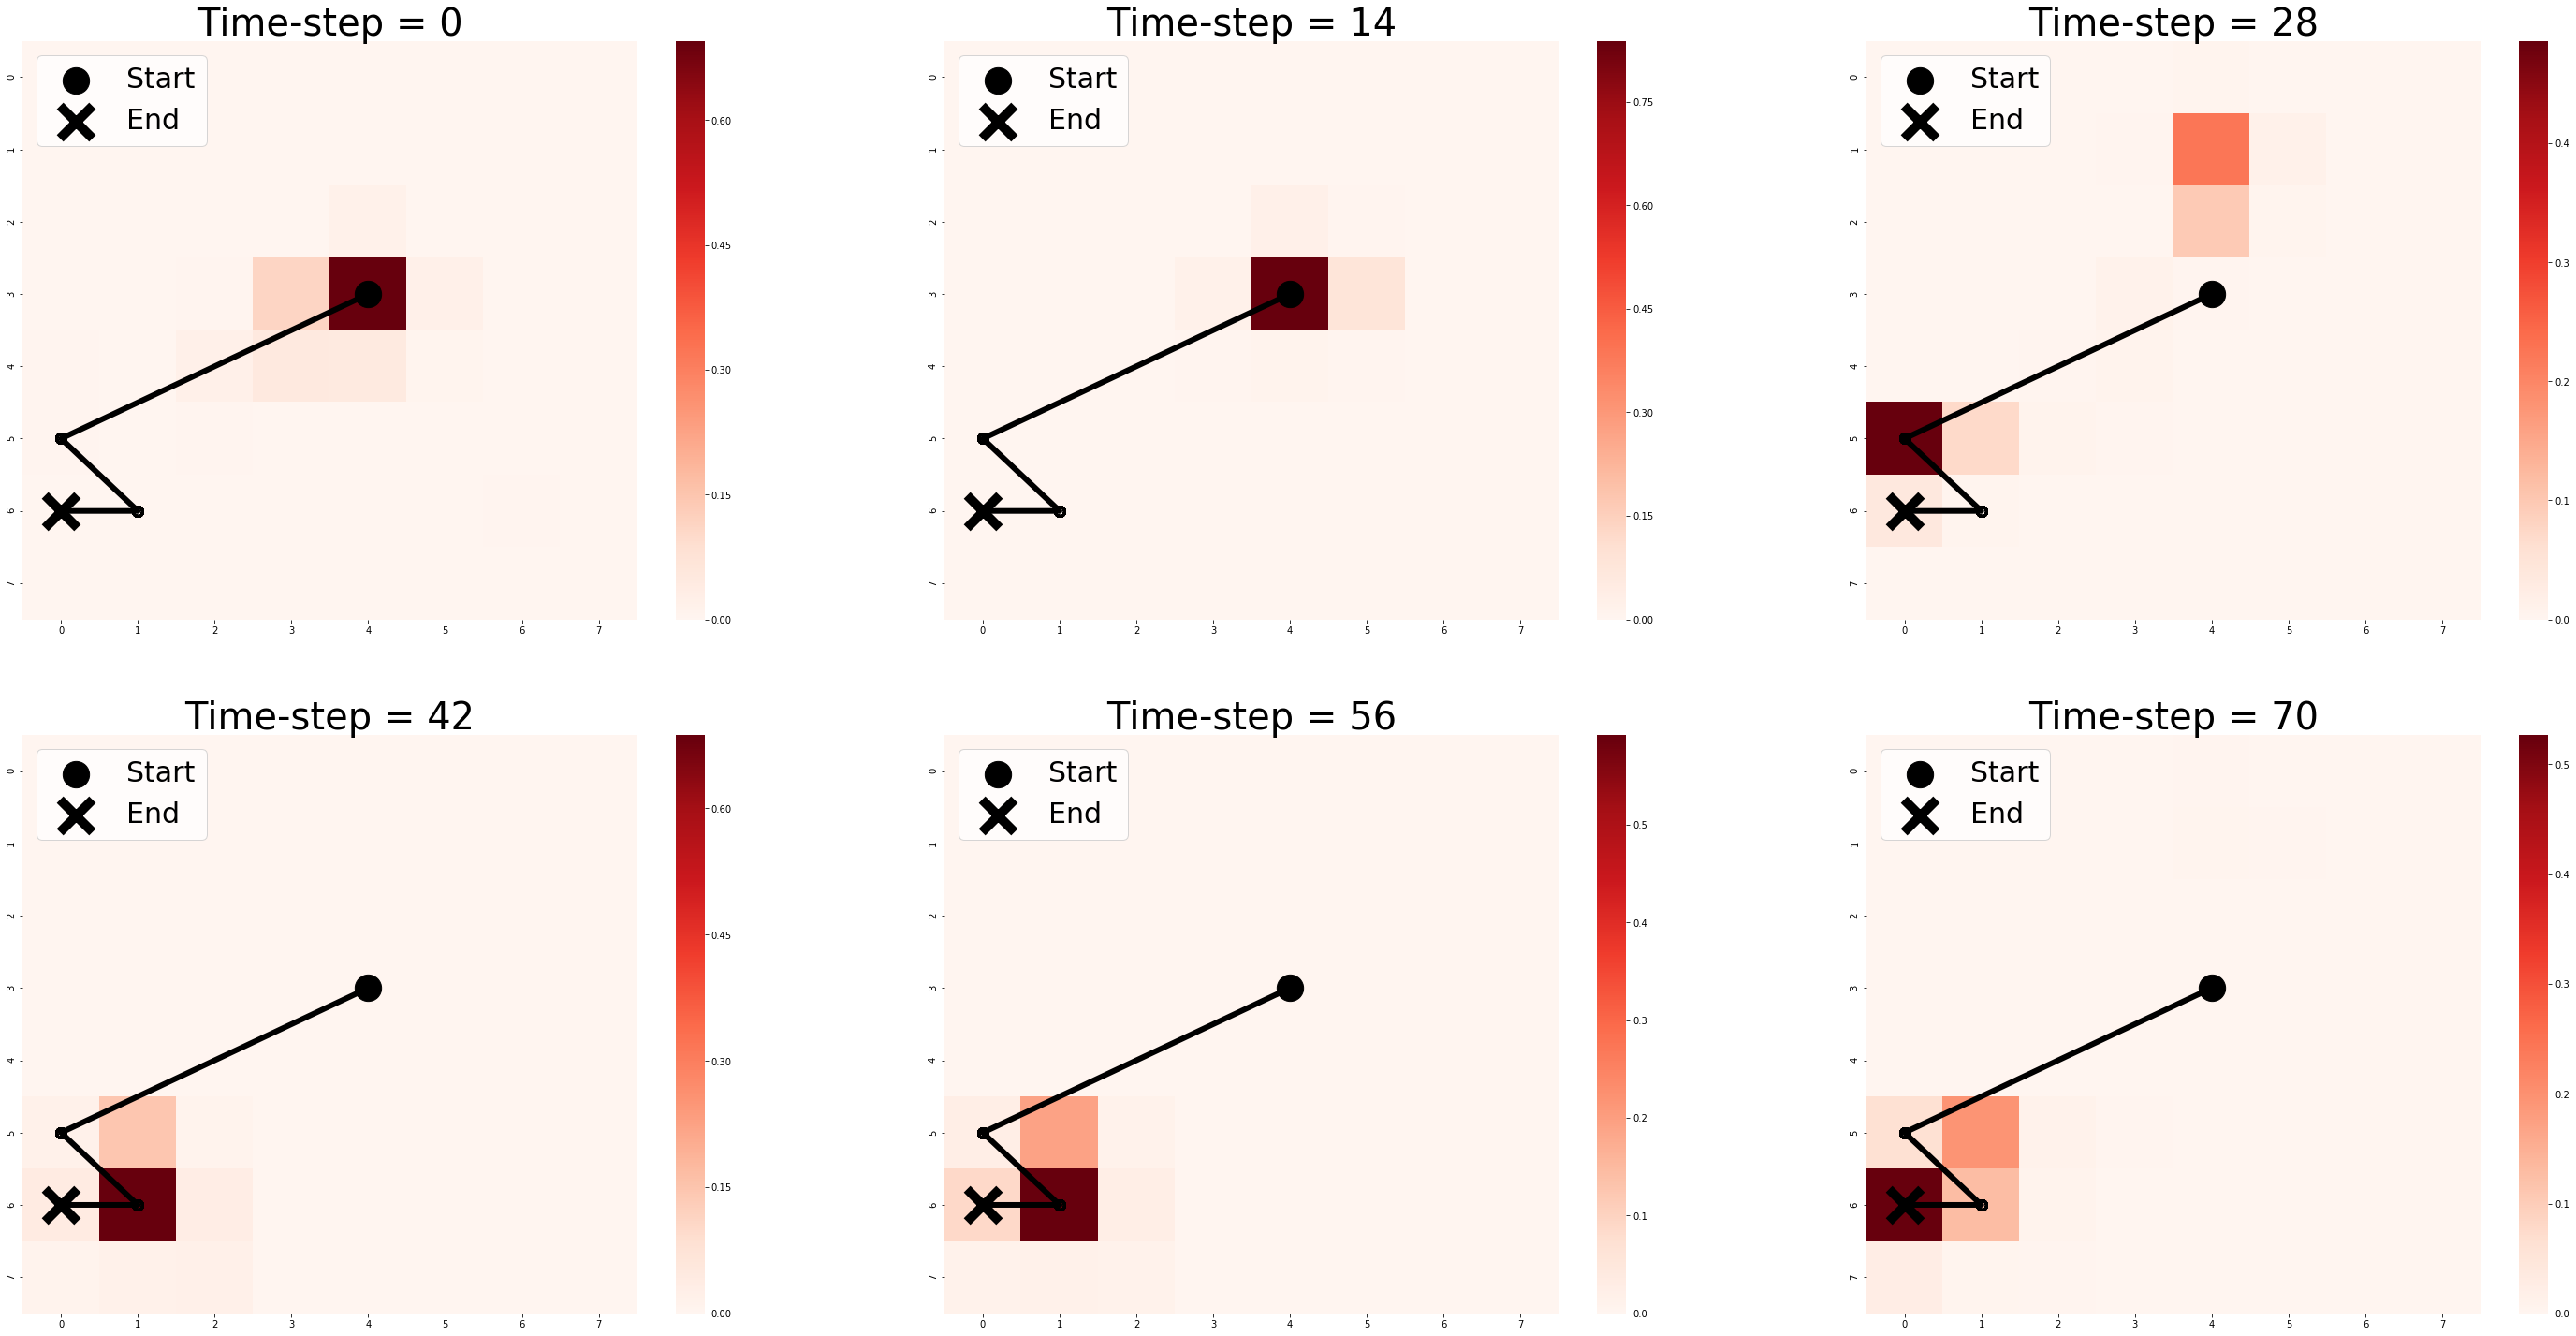

In [79]:
prob_q = np.reshape(qq, (-1, 72, 64)) 
i = np.random.randint(0, 50) #Randomly sampled patient
it = 0
fig, ax = plt.subplots(2, 3, figsize=(50,25))
for t in [0, 17, 40, 57, 64, 71]:
    cc = it % 3
    rr = it // 3
    k_1 = k_all[i] // som_dim[1]
    k_2 = k_all[i] % som_dim[1]
    c = "black"
    g1 = sns.heatmap(np.reshape(prob_q[i, t], (8,8)), cmap='Reds', alpha=1,  ax=ax[rr][cc])
    ax[rr][cc].plot(k_2[:] + 0.5, k_1[:] + 0.5, color=c, linewidth=6)
    ax[rr][cc].scatter(k_2[0] + 0.5, k_1[0] + 0.5, color=c, s=800, label='Start')
    ax[rr][cc].scatter(k_2[1:-1] + 0.5, k_1[1:-1] + 0.5, color=c, linewidth=10, marker='.')
    ax[rr][cc].scatter(k_2[-1] + 0.5, k_1[-1] + 0.5, color=c, s=1200, linewidth=10, marker='x', label='End')
    ax[rr][cc].legend(loc=2, prop={'size': 30})  
    ax[rr][cc].set_title("Time-step = {}".format(it*14), fontsize=40)
    it +=1
plt.show()

## Unrolling future time-steps and prediction

In [80]:
def z_dist_flat(z_e, embeddings):
    """Computes the distances between the encodings and the embeddings."""
    emb = np.reshape(embeddings, (som_dim[0]*som_dim[1], -1))
    z = np.reshape(z_e, (z_e.shape[0], 1, latent_dim))
    z = np.tile(z, [1,som_dim[0]*som_dim[1], 1])
    z_dist = np.square(z-emb)
    z_dist_red = np.sum(z_dist, axis=-1)
    return z_dist_red

In [81]:
tf.reset_default_graph()
num_pred = 6
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.import_meta_graph(modelpath+".meta")
    saver.restore(sess, modelpath)
    graph = tf.get_default_graph()
    k = graph.get_tensor_by_name("k/k:0")
    z_e = graph.get_tensor_by_name("z_e_sample/z_e:0")
    next_z_e = graph.get_tensor_by_name("prediction/next_state/next_z_e:0")
    x = graph.get_tensor_by_name("inputs/x:0")
    is_training = graph.get_tensor_by_name("is_training/is_training:0")
    graph = tf.get_default_graph()
    init_1 = graph.get_tensor_by_name("prediction/next_state/init_state:0")
    z_e_p = graph.get_tensor_by_name("prediction/next_state/input_lstm:0")
    state1 = graph.get_tensor_by_name("prediction/next_state/next_state:0")
    q = graph.get_tensor_by_name("q/distribution/q:0")
    embeddings = graph.get_tensor_by_name("embeddings/embeddings:0")
    z_p = graph.get_tensor_by_name("input_rec/z_e:0")
    reconstruction = graph.get_tensor_by_name("reconstruction_e/x_hat:0")
    
    print("Evaluation...")
    training_dic = {is_training: True, z_e_p: np.zeros((max_n_step * len(data_val), latent_dim)),
                    init_1: np.zeros((2, batch_size, 10))}
    
    z_e_all = sess.run(z_e, feed_dict={x: data_val})
    z_e_all = z_e_all.reshape((-1, 72, latent_dim))
    k_all = sess.run(k, feed_dict={x: data_val})
    k_all = k_all.reshape((-1, 72))
    qq = sess.run(q, feed_dict={x: data_val})
    x_rec = sess.run(reconstruction, feed_dict={x: data_val, is_training: True, z_p: np.zeros((max_n_step * len(data_val), latent_dim))})
    t = 72-num_pred
    embeddings = sess.run(embeddings, feed_dict={x: data_val[:, :t, :]})
    embeddings = np.reshape(embeddings,(-1,latent_dim))
    k_eval=[]
    batch_data= data_val[:, :t, :]
    z_e_o = z_e_all[:, :t, :]
    k_o = k_all[:, :t]
    f_dic = {x: batch_data}
    f_dic.update(training_dic)
    next_z_e_o = sess.run(next_z_e, feed_dict=f_dic)
    next_z_e_o = next_z_e_o[:, -1, :]
    state1_o = sess.run(state1, feed_dict=f_dic)
    k_next = np.argmin(z_dist_flat(next_z_e_o, embeddings), axis=-1)
    k_o = np.concatenate([k_o, np.expand_dims(k_next,1)], axis=1)
    z_e_o = np.concatenate([z_e_o, np.expand_dims(next_z_e_o, 1)], axis=1)
    f_dic = {x: np.zeros((len(data_val),1, 98)), is_training: False, z_e_p: np.zeros((1 * len(data_val), latent_dim)),
             z_p: next_z_e_o, init_1: np.zeros((2, batch_size, 10))}
    x_pred_hat = np.reshape(sess.run(reconstruction, feed_dict=f_dic), (-1, 1, 98))
    for i in range(num_pred-1):
        print(i)
        inp = data_val[:, (t + i), :]
        f_dic = {x: np.reshape(inp, (inp.shape[0],1,inp.shape[1]))}
        val_dic = {is_training: False, z_e_p: next_z_e_o, init_1: state1_o, z_p: np.zeros((max_n_step * len(data_val), latent_dim))}
        f_dic.update(val_dic)
        next_z_e_o = sess.run(next_z_e, feed_dict=f_dic)
        state1_o = sess.run(state1, feed_dict=f_dic)
        k_next = np.argmin(z_dist_flat(next_z_e_o, embeddings), axis=-1)
        k_o = np.concatenate([k_o, np.expand_dims(k_next,1)], axis=1)
        z_e_o = np.concatenate([z_e_o, next_z_e_o], axis=1)
        next_z_e_o = np.reshape(next_z_e_o, (-1, latent_dim))
        f_dic = {x: np.zeros((len(data_val),1, 98)), is_training: False, z_e_p: np.zeros((max_n_step * len(data_val), latent_dim)),
             z_p: next_z_e_o, init_1: np.zeros((2, batch_size, 10))}
        final_x = sess.run(reconstruction, feed_dict=f_dic)
        x_pred_hat = np.concatenate([x_pred_hat, np.reshape(final_x, (-1, 1, 98))], axis = 1)
    
    f_dic = {x: np.zeros((len(data_val),1, 98)), is_training: False, z_e_p: np.zeros((max_n_step * len(data_val), latent_dim)),
             z_p: z_e_all[:, t-1, :], init_1: np.zeros((2, batch_size, 10))}
    final_x = sess.run(reconstruction, feed_dict=f_dic)

INFO:tensorflow:Restoring parameters from ../models/hyperopt_LSTMprob_10_8-8_2019-10-02_bcbff/hyperopt_LSTMprob_10_8-8_2019-10-02_bcbff
Evaluation...
0
1
2
3
4


In [82]:
sklearn.metrics.mean_squared_error(np.reshape(x_pred_hat, (-1, 98)), np.reshape(data_val[:, -6:], (-1, 98)))

0.02578137195091756

Accuracy of unrolled state:

In [86]:
k_true = np.reshape(k_all[:, -num_pred:], (-1))
k_pred = np.reshape(k_o[:, -num_pred:], (-1))
tot = 0
acc = 0
for i in range(len(k_true)):
    tot += 1
    if k_true[i] == k_pred[i]:
        acc += 1
acc = acc / tot
acc

0.5157828282828283

SAME-STATE baseline:

In [84]:
x_same = np.reshape(final_x, (-1,1, 98))
for i in range(5):
    x_same = np.concatenate([x_same, np.reshape(final_x, (-1,1, 98))], axis=1)
x_same=np.array(x_same)
sklearn.metrics.mean_squared_error(np.reshape(x_same, (-1, 98)), np.reshape(data_val[:, -6:], (-1, 98)))

0.05851914833519881